useful links:

- Data Preparation for Variable Length Input Sequences, URL: https://machinelearningmastery.com/data-preparation-variable-length-input-sequences-sequence-prediction/
- Masking and padding with Keras, URL: https://www.tensorflow.org/guide/keras/masking_and_padding
- Step-by-step understanding LSTM Autoencoder layers, URL: https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352XX, 
- Understanding input_shape parameter in LSTM with Keras, URL: https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras
- tf.convert_to_tensor, URL: https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor
- ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) in Python, URL: https://datascience.stackexchange.com/questions/82440/valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupported-object-type

In [1027]:
"""
* Copyright 2020, Maestria de Humanidades Digitales,
* Universidad de Los Andes
*
* Developed for the Msc graduation project in Digital Humanities
*
* This program is free software: you can redistribute it and/or modify
* it under the terms of the GNU General Public License as published by
* the Free Software Foundation, either version 3 of the License, or
* (at your option) any later version.
*
* This program is distributed in the hope that it will be useful,
* but WITHOUT ANY WARRANTY; without even the implied warranty of
* MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
* GNU General Public License for more details.
*
* You should have received a copy of the GNU General Public License
* along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# ===============================
# native python libraries
# ===============================
import re
import random
import json
import csv
import datetime
import copy
from collections import OrderedDict
from collections import Counter
from collections import deque

# ===============================
# extension python libraries
# ===============================
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt

# natural language processing packages
import gensim
from gensim import models
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# downloading nlkt data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# sample handling sklearn package
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain

# # Keras + Tensorflow ML libraries
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.optimizers import SGD

# ===============================
# developed python libraries
# ===============================

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Felipe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1028]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.

taken from https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
'''
def temporalize(data, lookback):
    output_X = list()
    for i in range(len(X)-lookback-1):
        temp = list()
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            temp.append(data[[(i+j+1)], :])
        temp = np.array(temp, dtype="object")
        output_X.append(temp)
    output_X = np.array(output_X, dtype="object")
    return output_X

In [1029]:
# variable definitions
# root folder
dataf = "Data"

# subfolder with predictions txt data
targetf = "Target"

# report subfolder
reportf = "Reports"

#  subfolder with the CSV files containing the ML pandas dataframe
stdf = "Std"

# dataframe file extension
fext = "csv"

imgext = "jpg"

# dictionary extension
dext = "dict"

# standard sufix
stdprefix = "std-"

# ml model useful data
mltprefix = "ml-"

# report names
str_date = datetime.date.today().strftime("%d-%b-%Y")

small_sufix = "Text-Data-Small"
large_sufix = "Text-Data-Large"

gallery_prefix = "VVG-Gallery"

# dataframe file name
small_fn = stdprefix + gallery_prefix + "-" + small_sufix + "." + fext
large_fn = stdprefix + gallery_prefix + "-" + large_sufix + "." + fext

# dictionary file name
sdict_fn = "VVG-Gallery-Text-Data-Small" + "." + dext
ldict_fn = "VVG-Gallery-Text-Data-Large" + "." + dext

# ramdom seed
randseed = 42

# window size
min_wsize = 30
max_wsize = 60
def_wsize = int((min_wsize+max_wsize)/2)

# sample distribution train vs test sample size
trainf = 0.80
testf = 0.20

# regex to know that column Im interested in
keeper_regex = r"(^ID$)|(^std_)"

# default values
# work_fn, work_dict, work_sufix = small_fn, sdict_fn, small_sufix
work_fn, work_dict, work_sufix  = large_fn, ldict_fn, large_sufix

In [1030]:
root_folder = os.getcwd()
root_folder = os.path.split(root_folder)[0]
root_folder = os.path.normpath(root_folder)
print(root_folder)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer


In [1031]:
# variable reading
# dataframe filepath
fn_path = os.path.join(root_folder, dataf, stdf, work_fn)
print(fn_path)

# gensim dictionart filepath
dict_path = os.path.join(root_folder, dataf, stdf, work_dict)
print(dict_path)

c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Std\std-VVG-Gallery-Text-Data-Small.csv
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Std\VVG-Gallery-Text-Data-Small.dict


In [1032]:
# reading words dictionary
# loading gesim words dictionary
vvg_dict = gensim.corpora.Dictionary()
vvg_dict = vvg_dict.load(dict_path)
print(vvg_dict)

Dictionary(599 unique tokens: ['1', '11', '16', '1885', '1891']...)


In [1033]:
# rading training data
# loading file
source_df = pd.read_csv(
                fn_path,
                sep=",",
                encoding="utf-8",
                engine="python",
            )

In [1034]:
# checking everything is allrigth
source_df.head(5)
# chekcing the dataframe
source_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     59 non-null     object
 1   F-number               59 non-null     object
 2   JH-number              59 non-null     object
 3   creator-date           59 non-null     object
 4   creator-place          59 non-null     object
 5   Dimensions             59 non-null     object
 6   details                59 non-null     object
 7   MUS_TEXT               59 non-null     object
 8   std_cat_creator-date   59 non-null     object
 9   std_cat_creator-place  59 non-null     object
 10  std_cat_Dimensions     59 non-null     object
 11  std_cat_details        59 non-null     object
 12  clr_tokens             59 non-null     object
 13  lemmas                 59 non-null     object
 14  bows_tokens            59 non-null     object
 15  idxs_tokens            59

In [1035]:
# selecting data to train
# want to keep the columns starting with STD_
df_columns = list(source_df)
print("original input/interested columns:\n",  df_columns)
# create the columns Im interesting in
keep_columns = [i for i in df_columns if re.search(keeper_regex, i)]

print("\nInteresting columns:\n", keep_columns)

original input/interested columns:
 ['ID', 'F-number', 'JH-number', 'creator-date', 'creator-place', 'Dimensions', 'details', 'MUS_TEXT', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'clr_tokens', 'lemmas', 'bows_tokens', 'idxs_tokens', 'tfidf_tokens', 'std_dvec_tokens']

Interesting columns:
 ['ID', 'std_cat_creator-date', 'std_cat_creator-place', 'std_cat_Dimensions', 'std_cat_details', 'std_dvec_tokens']


In [1036]:
# checking the number of max num on labels in the categories
too_disperse = None
tcount = 0
for label_col in keep_columns:
    label_count = source_df[label_col].value_counts(normalize=False)

    if tcount < label_count.shape[0] and ("std_cat_" in label_col):
        tcount = label_count.shape[0]
        too_disperse = label_col

    print("***", label_col, ":", label_count.shape)#.__dict__)

print(too_disperse, tcount)

*** ID : (59,)
*** std_cat_creator-date : (16,)
*** std_cat_creator-place : (5,)
*** std_cat_Dimensions : (52,)
*** std_cat_details : (11,)
*** std_dvec_tokens : (45,)
std_cat_Dimensions 52


In [1037]:
# creating the training dataframe
keep_columns.remove(too_disperse)
keep_columns.remove("ID")
print("------ Interesting columns ------")
print(keep_columns)
train_df = pd.DataFrame(source_df, columns=keep_columns)

------ Interesting columns ------
['std_cat_creator-date', 'std_cat_creator-place', 'std_cat_details', 'std_dvec_tokens']


In [1038]:
# getting the column with the relevant data to train
dvector_col = [i for i in df_columns if re.search(u"^std_dvec", i)]
dvector_col = dvector_col[0]
print("Dense vector column in dataframe: ", str(dvector_col))

Dense vector column in dataframe:  std_dvec_tokens


In [1039]:
# fix column data type
work_corpus = train_df[dvector_col]
dvec_std_corpus = list()

for dvector in work_corpus:
    dvector = eval(dvector)
    dvector = np.array(dvector)
    dvec_std_corpus.append(dvector)

dvec_std_corpus = np.array(dvec_std_corpus, dtype="object")

In [1040]:
# changing type in dataframe
train_df[dvector_col] = dvec_std_corpus

In [1041]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   std_cat_creator-date   59 non-null     object
 1   std_cat_creator-place  59 non-null     object
 2   std_cat_details        59 non-null     object
 3   std_dvec_tokens        59 non-null     object
dtypes: object(4)
memory usage: 2.0+ KB


In [1042]:
# padding training data according to max length of text corpus
pad_prefix = "pad_"
recurrent_prefix = "lstm_"
padded_corpus = None

# getting the corpus dense vectors
dvec_std_corpus = train_df[dvector_col]

# converting list of list to array of array
print(dvec_std_corpus.shape)

# padding the representation
padded_corpus = pad_sequences(dvec_std_corpus, dtype='object', padding="post")
print(padded_corpus.shape)

# creating the new column and saving padded data
padded_col = pad_prefix + dvector_col

# print(padded_col)
train_df[padded_col] = list(padded_corpus)
print(padded_corpus.shape)

(59,)
(59, 142)
(59, 142)


In [1043]:
# funct to concatenate all label columns into one for a single y in ML training, returns a list
def concat_labels(row, cname):
    ans = list()
    for c in cname:

        r = row[c]
        r = eval(r)
        ans = ans + r

    return ans

In [1044]:
# getting the columns with the relevant labels to predict
print(keep_columns)
labels_cols = [i for i in keep_columns if re.search(u"^std_cat_", i)]
print("Trainable labels columns in dataframe: ", str(labels_cols))

labels_data = train_df[labels_cols]
labels_concat = list()

# concatenating all category labels from dataframe
for index, row in labels_data.iterrows():
    # print(row.shape)
    row = concat_labels(row, labels_cols)
    # print(len(row))
    labels_concat.append(row)

['std_cat_creator-date', 'std_cat_creator-place', 'std_cat_details', 'std_dvec_tokens']
Trainable labels columns in dataframe:  ['std_cat_creator-date', 'std_cat_creator-place', 'std_cat_details']


In [1045]:
print(len(labels_concat[0]), type(labels_concat[0]))

32 <class 'list'>


In [1046]:
# updating dataframe
tcat_label_col = "std_cat_labels"
train_df[tcat_label_col] = labels_concat

In [1047]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   std_cat_creator-date   59 non-null     object
 1   std_cat_creator-place  59 non-null     object
 2   std_cat_details        59 non-null     object
 3   std_dvec_tokens        59 non-null     object
 4   pad_std_dvec_tokens    59 non-null     object
 5   std_cat_labels         59 non-null     object
dtypes: object(6)
memory usage: 2.9+ KB


In [1048]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
X = np.array([np.array(i, dtype="object") for i in train_df[padded_col]], dtype="object")
y = np.array([np.array(j, dtype="object") for j in train_df[tcat_label_col]], dtype="object")

# X = train_df[padded_col]
# y = train_df[padded_col]

print(X.shape)
print(y.shape)

(59, 142)
(59, 32)


In [1049]:
# balancing classes to train
lstm_lp = LabelPowerset()
lstm_smote = RandomOverSampler(random_state = randseed)

Xt = X
yt = lstm_lp.transform(y.astype("int"))
X_b, y_b = lstm_smote.fit_resample(Xt, yt)
y_b = lstm_lp.inverse_transform(y_b)
y_b = y_b.toarray()

print("Balance X:", X_b.shape)
print("Balance y:", y_b.shape)

Balance X: (288, 142)
Balance y: (288, 32)


In [1050]:
# creating Train/Test sample
# getting the X, y to train, as is autoencoder both are the same
X = X_b#np.array([np.array(i, dtype="object") for i in X_b], dtype="object")
y = y_b#np.array([np.array(j, dtype="object") for j in y_b], dtype="object")

# X = train_df[padded_col]
# y = train_df[padded_col]

print(X.shape)
print(y.shape)

(288, 142)
(288, 32)


In [1051]:
print(type(X[0]))
print(type(X[0][0]))
print(X.shape)

<class 'numpy.ndarray'>
<class 'float'>
(288, 142)


In [1052]:
print(type(y[0]))
print(type(y[0][0]))
print(y.shape)

<class 'numpy.ndarray'>
<class 'numpy.int64'>
(288, 32)


In [1053]:
# timestep is the memory of what i read, this is the longest sentence I can remember in the short term
# neet to look for the best option, in small the max is 15
timesteps = 15

# features is the max length in the corpus, after padding!!!!
features = X.shape[1]
labels = y.shape[1]
print(timesteps, features, labels)

15 142 32


In [1054]:
# preparation for reshape lstm model
Xt = temporalize(X, timesteps)
# yt = temporalize(y, timesteps)
yt = y

In [1055]:
print(Xt.shape)
print(yt.shape)

(272, 15, 1, 142)
(288, 32)


In [1056]:
# reshaping for LSTM model
X_lstm = Xt.reshape((Xt.shape[0], timesteps, features))
print(X_lstm.shape)
# y_lstm = yt.reshape((yt.shape[0], timesteps, labels))
y_lstm = yt[0:X_lstm.shape[0]]
print(y_lstm.shape)

(272, 15, 142)
(272, 32)


In [1057]:
# creating the column for the reshape data according to LSTM
lstm_col = recurrent_prefix + dvector_col
print(lstm_col)

lstm_std_dvec_tokens


In [1058]:
# checking the train dataframe
train_df.head(5)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   std_cat_creator-date   59 non-null     object
 1   std_cat_creator-place  59 non-null     object
 2   std_cat_details        59 non-null     object
 3   std_dvec_tokens        59 non-null     object
 4   pad_std_dvec_tokens    59 non-null     object
 5   std_cat_labels         59 non-null     object
dtypes: object(6)
memory usage: 2.9+ KB


In [1059]:
# data to numpy format
X_lstm = np.asarray(X_lstm).astype(np.float)
y_lstm = np.asarray(y_lstm).astype(np.float)
print(X_lstm.shape)
print(y_lstm.shape)

(272, 15, 142)
(272, 32)


In [1060]:
# dividing according to train/test proportions
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, train_size = trainf, test_size = testf, random_state = randseed)

In [1061]:
# checking shaped
print("training shape (X, y)")
print("X: ", X_train.shape, " y: ", y_train.shape)

print("testing shape (X, y)")
print("X: ", X_test.shape, " y: ", y_test.shape)

print("data types")
print(type(X_train), type(X_test), type(y_train), type(y_test))
print(type(X_train[0]), type(X_test[0]), type(y_train[0]), type(y_test[0]))
print(type(X_train[0][0]), type(X_test[0][0]), type(y_train[0][0]), type(y_test[0][0]))
print(type(X_train[0][0][0]), type(X_test[0][0][0]), type(y_train[0][0]), type(y_test[0][0]))

training shape (X, y)
X:  (217, 15, 142)  y:  (217, 32)
testing shape (X, y)
X:  (55, 15, 142)  y:  (55, 32)
data types
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'> <class 'numpy.float64'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


In [1062]:
Xtf_train = tf.convert_to_tensor(X_train, dtype="float64")
Xtf_test = tf.convert_to_tensor(X_test, dtype="float64")
ytf_train = tf.convert_to_tensor(y_train, dtype="float64")
ytf_test = tf.convert_to_tensor(y_test, dtype="float64")

# y_tensor = tf.convert_to_tensor(y, dtype=tf.float23) 

In [1063]:
# number of neurons or processing units in LSTM
# the number is because of good practices for NLP
# min 200 max 500, normaly 300 (related to the semantic number of themes)
# 120 for now in this test
lstm_units = 500

# timestep is 1 because you read a word at a time
memory = timesteps
print("LSTM memory span:", memory)

# features is the max length in the corpus, after padding!!!!
features = X_train.shape[2]
print("LSTM learning features:", features)

# batch size
bs = int(X_train.shape[0]*0.05)
print("LSTM learning batch size:", bs)

print("LSMT processing units:", lstm_units)

# configuration to remember previous recurrent layer
rs = True

# neurons/processing units size in the dense layer (THIS SHOULD BE SOM!!!!)
dn1 = 32*32
print("Dense processing units:", dn1)
# dn2 = len(XB_set[0])*SECURITY_FACTOR

# numero de neuronas de salida
outn = y_train.shape[1]
print("Output prediction units:", outn)

# axtivation functions
inn = "relu"
act = "selu"
# act = "softmax"
out = "softmax"
# out = "sigmoid"
# out = "relu"

# loss percentage
ldrop = 0.2

# random seed
randseed = 42

# parameters to compile model
# loss function
ls = "binary_crossentropy"
# ls = "categorical_crossentropy"
# ls = "sparse_categorical_crossentropy"
# ls = "mean_squared_error"
# ls = "mean_absolute_error"
# ls = "cosine_similarity"

# optimization function
# opti = "adam"
# opti = SGD(lr=0.01, momentum=0.9, decay=0.01)
# opti = "adagrad"
opti = "RMSprop"

# evaluation score
met = ["accuracy"]

# parameters to exeute training
# verbose mode
ver = 1
# training epocha
epo = 500
print("training epochs:", epo)

LSTM memory span: 15
LSTM learning features: 142
LSTM learning batch size: 10
LSMT processing units: 500
Dense processing units: 1024
Output prediction units: 32
training epochs: 500


In [1064]:
# model layers
# to avoid overfit you need to use dropout in someplaces
# options:
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Drop -> Dense -> Drop -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 1) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM3 -> Dense -> LSTM3 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 2) Mask -> Drop -> LSTM1 -> LSTM2 -> LSTM2 -> Dense -> LSTM2 -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> LSTM2 -> Drop -> Dense -> Drop -> LSTM2 -> LSTM1 -> Drop -> TimeDistDense
# 3) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> STM1 -> Drop -> TimeDistDense
# 5) Mask -> Drop -> LSTM1 -> Drop -> Dense -> Drop -> LSTM1 -> TimeDistDense
lstm_layers = (

    # input layer (padding and prep)
    Masking(mask_value=0.0, input_shape=(memory, features), name = "LayMask"),

    # intermediate recurrent encoder layer
    LSTM(lstm_units, activation=inn, input_shape=(memory, features), return_sequences=rs, recurrent_dropout = ldrop, name = "EnLSTM_1"),
    SpatialDropout1D(ldrop, name = "EnDrop_1"),
    # Dropout(ldrop, name = "EnDrop_1"),

    # intermediate recurrent encoder layer
    LSTM(int(lstm_units/2), activation=inn, input_shape=(timesteps, features), return_sequences=rs, name = "EnLSTM_2"),
    # Dropout(ldrop, name = "EnDrop_2"),

    # intermediate recurrent encoder layer
    LSTM(int(lstm_units/4), activation=inn, input_shape=(timesteps, features), return_sequences=False, name = "EnLSTM_3"),
    Dropout(ldrop, name = "EnDrop_3"),    

    # # intermediate recurrent encoder layer
    # LSTM(int(lstm_units/8), activation=inn, input_shape=(timesteps, features), return_sequences=False, name = "EnLSTM_4"),
    # SpatialDropout1D(ldrop, name = "EnDrop_4"),  
    # from 2D to 1D
    # Flatten(name = "LayFlat1"),
    # Flatten(name = "LayFlat2"),

    # mid dense encoding layer
    # dense layer for abstraction (THIS SHOULD COULD SOM!!!!)    
    Dense(dn1, activation=act, name = "MidDense"),
    Dropout(ldrop, name = "DeDrop_1"),
    # Flatten(name = "LyFlat1"),
    # Flatten(name = "LyFlat2"),

    # intermediate dense classification layer
    Dense(int(dn1/2), activation=act, name = "ClsDense_1"),
    # Dropout(ldrop, name = "ClsDrop_1"),

    # intermediate dense classification layer
    Dense(int(dn1/4), activation=act, name = "ClsDense_2"),
    Dropout(ldrop, name = "ClsDrop_2"),

    # intermediate dense classification layer
    # Dense(int(dn1/8), activation=act, name = "ClsDense_3"),
    # Dropout(ldrop, name = "ClsDrop_3"),

    # output layer, dense time sequential layer.
    Dense(outn, activation=out, name = "LayClsOut"),
    # TimeDistributed(Dense(outn, activation=out), name = "LayClsOut"),
)

In [1065]:
# defining model
lstm_model = Sequential(lstm_layers)
lstm_model.model_name = "LSTM_Classifier"

In [1066]:
# compile model
lstm_model.compile(loss = ls, optimizer = opti, metrics = met)
lstm_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LayMask (Masking)            (None, 15, 142)           0         
_________________________________________________________________
EnLSTM_1 (LSTM)              (None, 15, 500)           1286000   
_________________________________________________________________
EnDrop_1 (SpatialDropout1D)  (None, 15, 500)           0         
_________________________________________________________________
EnLSTM_2 (LSTM)              (None, 15, 250)           751000    
_________________________________________________________________
EnLSTM_3 (LSTM)              (None, 125)               188000    
_________________________________________________________________
EnDrop_3 (Dropout)           (None, 125)               0         
_________________________________________________________________
MidDense (Dense)             (None, 1024)            

In [1067]:
# early stopping condition BECAAUSE THIS ARE TESTS
EarlyStopLSTM_Acc = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 60, verbose = 1, mode = "max", restore_best_weights = True)
EarlyStopLSTM_Loss = EarlyStopping(monitor = "val_loss", min_delta = 0.001, patience = 60, verbose = 1, mode = "max", restore_best_weights = True)


In [1068]:
# training model
history_lstm = lstm_model.fit(
    x = Xtf_train, 
    y = ytf_train,
    epochs = epo, 
    verbose = ver, 
    workers = 7,
    batch_size = bs, 
    callbacks = [EarlyStopLSTM_Acc], #, EarlyStopLSTM_Loss],
    shuffle = False,
    use_multiprocessing = True,
    validation_data = (Xtf_test, ytf_test),
)

Epoch 1/500
22/22 [==============================] - 13s 268ms/step - loss: 1.1298 - accuracy: 0.0163 - val_loss: 0.2781 - val_accuracy: 0.0000e+00
Epoch 2/500
22/22 [==============================] - 5s 222ms/step - loss: 0.2704 - accuracy: 0.0000e+00 - val_loss: 0.2523 - val_accuracy: 0.0000e+00
Epoch 3/500
22/22 [==============================] - 5s 229ms/step - loss: 0.2530 - accuracy: 0.0000e+00 - val_loss: 0.2187 - val_accuracy: 0.0000e+00
Epoch 4/500
22/22 [==============================] - 5s 217ms/step - loss: 0.2342 - accuracy: 0.0100 - val_loss: 0.2313 - val_accuracy: 0.0000e+00
Epoch 5/500
22/22 [==============================] - 5s 220ms/step - loss: 0.2253 - accuracy: 0.0176 - val_loss: 0.2379 - val_accuracy: 0.0000e+00
Epoch 6/500
22/22 [==============================] - 5s 215ms/step - loss: 0.2120 - accuracy: 0.0461 - val_loss: 0.2275 - val_accuracy: 0.1273
Epoch 7/500
22/22 [==============================] - 5s 208ms/step - loss: 0.2060 - accuracy: 0.0578 - val_loss: 

In [1069]:
# evaluationg model
lstm_eval = lstm_model.evaluate(x = Xtf_test, y = ytf_test)

2/2 [==============================] - 0s 78ms/step - loss: 0.1564 - accuracy: 0.4727


In [1070]:
# general evaluation 
print("avg loss: ", lstm_eval[0])
print("avg acc: ", lstm_eval[1])

avg loss:  0.15642936527729034
avg acc:  0.4727272689342499


In [1071]:
# testing model
lstm_results = lstm_model.predict(X_test, batch_size = bs, verbose = 1)#, batch_size = bs)

6/6 [==============================] - 1s 54ms/step


In [1072]:
lstm_results[0].shape

(32,)

In [1073]:
# saving model
wdir = os.getcwd()
models_folder = "Models"
model_fname = "vvg_lstm_classifier"
model_fpn = os.path.join(root_folder, dataf, models_folder, model_fname)
print("The trained  model is:", model_fpn)
lstm_model.save(model_fpn)

The trained  model is: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_lstm_classifier
INFO:tensorflow:Assets written to: c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Models\vvg_lstm_classifier\assets


In [1074]:
# cheking test shape
print(lstm_results.shape)

(55, 32)


In [1075]:
print(y_test[0].shape, "\n***************\n", lstm_results[0].shape)
for y, r in zip(y_test, lstm_results):
    print(len(y),  len(r))
    r = r.round(2)
    print(y, "\n", list(r))
    

(32,) 
***************
 (32,)
32 32
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0.] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
32 32
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
32 32
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.] 
 [0.0, 0.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
32 32
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.] 
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

<ipython-input-1076-27ae52336ddd>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


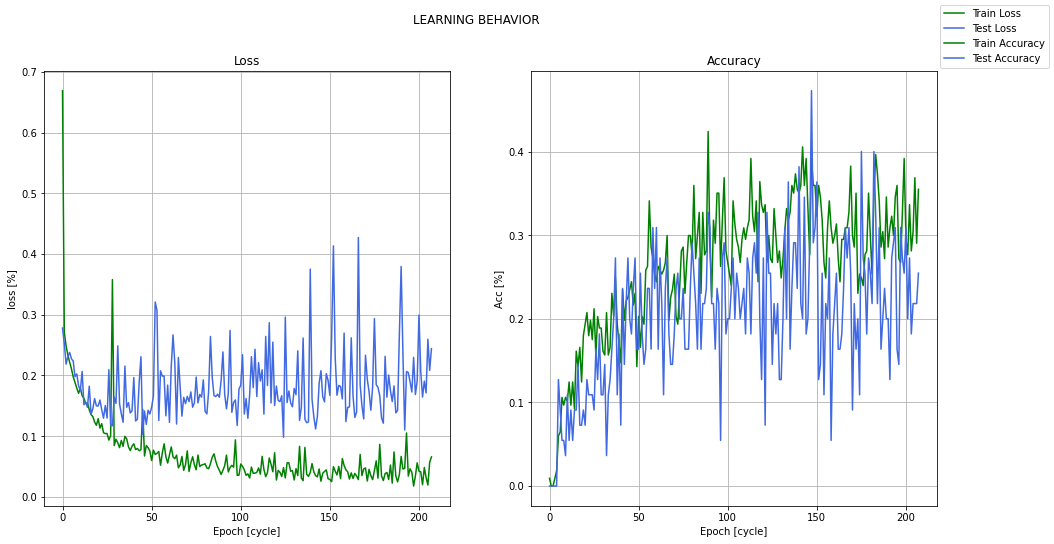

In [1076]:
# reporting results
# reporte de entrenamiento para el modelo
# base de la figura
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))

# datos de la figura en de perdida y precision
ax1.plot(history_lstm.history["loss"], 'green', label = "Train Loss")
ax1.plot(history_lstm.history["val_loss"], 'royalblue', label = "Test Loss")
ax2.plot(history_lstm.history["accuracy"], 'green', label = "Train Accuracy")
ax2.plot(history_lstm.history["val_accuracy"], 'royalblue', label = "Test Accuracy")

# leyenda de la grafica
fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

In [1077]:
# saving image in png file
work_learn_img = model_fname + "-" + str_date + "-" + work_sufix + "-learn-curve." + imgext
img_fpn = os.path.join(root_folder, dataf, reportf, work_learn_img)
print(os.path.exists(img_fpn))
print(img_fpn)

True
c:\Users\Felipe\Documents\GitHub\sa-artea\VVG-MLModel-Trainer\Data\Reports\vvg_lstm_classifier-14-May-2021-Text-Data-Small-learn-curve.jpg


In [1078]:
# saving rendered image
fig.savefig(img_fpn, dpi = fig.dpi)

In [1079]:
# FOR FUTURE USE!!!! DEMO!!!
lstm_test_text = """
                There is a khan's daughter
                Who steps on in a SWINGING manner
                And has the marks of twenty tigers,
                Who steps on in a GRACEFUL manner
                And has the marks of thirty manner
                Who steps on in an ELEGANT manner
                And has the marks of forty tigers,
                Who steps on in a DELICATE manner
                And has the marks of fifty tigers.
                # """